## Exploración de los datos

Variables del dataset:

 Features: El dataset contiene 6 features en 6 columnas, que son los parámetros medidos de los diferentes sensores. Estos corresponden a las vibraciones detectadas en el cohete.

 Target: El target corresponde al 'label' que clasifica los tipos de estados del cohete en función de los features medidos por los sensores.

   * Target 0 corresponde a Estable
   * Target 1 corresponde a Turbulencia Ligera
   * Target 2 corresponde a Turbulencia Moderada
   * Target 3 corresponde a Turbulencia Severa
   * Target 4 corresponde a Turbulencia Extrema

El objetivo del reto será realizar un modelo predictivo que permita conocer el tipo de erupción que tendrá un cohete en función de las vibraciones medidas por los sensores.

Una vez se haya hecho y entrenado el modelo predictivo, este se tendrá que emplear con los features del dataset de testing 'space_X_test.csv'. Estas predicciones se tendrán que entregar en formato csv donde tendrá que aparecer tan solo una columna en la que en la primera fila sea un texto cualquiera y las predicciones empiecen en la fila 2.

La calidad de la predicción se medirá a partir del f1-score (macro).

In [1]:
#data exploration
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

#preprocessing libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#model selection and algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("space_X_train.csv", index_col = 0)

In [3]:
df.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  target
0  0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367       4
1 -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838       0
2 -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928       1
3 -1.268179  2.770688  1.054193  2.830389  0.395093  0.677715       3
4 -1.216380 -0.391267 -2.898931 -0.913074 -2.171857 -2.367490       0

In [4]:
df.shape

(2100, 7)

In [5]:
df.isna().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [8]:
df.target.value_counts()

0    427
3    426
1    423
2    419
4    405
Name: target, dtype: int64

Los valores del target están balanceados, es decir, no hay valores subrepresentados. Tampoco hay datos faltantes en el dataset por lo que se puede seguir. Se procede a explorar las features. El objetivo es ver cómo se comportan para escoger qué feature engineering aplicarles, sobre todo, ver qué distribución tienen y si hay valores atípicos (outliers). 

In [3]:
features = df.drop("target", axis = 1)
features.describe()

sensor_1     sensor_2     sensor_3     sensor_4     sensor_5  \
count  2100.000000  2100.000000  2100.000000  2100.000000  2100.000000   
mean     -0.204656     0.199249    -0.378140    -0.206425    -0.186419   
std       1.543613     1.614024     1.450548     1.442225     1.501573   
min      -6.683655    -5.383371    -6.147055    -5.653594    -5.912521   
25%      -1.171340    -0.877386    -1.365990    -1.259403    -1.211685   
50%      -0.443868     0.320507    -0.439745    -0.176504    -0.195751   
75%       0.890023     1.321430     0.662898     0.866879     0.851843   
max       4.565547     6.700133     4.157518     4.371912     5.068783   

          sensor_6  
count  2100.000000  
mean     -0.433229  
std       1.188791  
min      -4.433189  
25%      -1.131944  
50%      -0.406754  
75%       0.348593  
max       4.016324

In [18]:
#show multicollinearity in features
def vif(X):
    vifDF = pd.DataFrame()
    vifDF["variables"] = X.columns
    vifDF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vifDF

vif(features)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


variables  VIF
0  sensor_1  inf
1  sensor_2  inf
2  sensor_3  inf
3  sensor_4  inf
4  sensor_5  inf
5  sensor_6  inf

El código ejecutado en la celda superior muestra un factor de inflación de la varianza (VIF) infinito. Cuanto más alto es este valor, más colinearidad hay entre features, y a partir de un VIF de 5 se considera ya colinearidad. En este caso, el infinito calculado se debe a que $r^{2}$, el valor que representa la colinearidad y correlación, es igual a 1, lo que provoca una división entre 0, como se ve en la siguiente fórmula:

$ VIF = \frac{1}{1 - r^{2}} $

Esto indica que aplicar análisis de componentes principales (PCA) podría ayudar al rendimiento del modelo. 

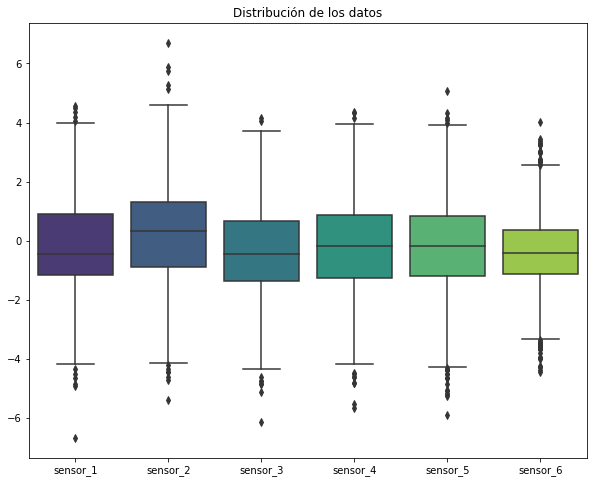

In [7]:
plt.figure(figsize = (10, 8))
sns.boxplot(data = features, palette = "viridis").set(title = "Distribución de los datos")
plt.show()

La gráfica muestra que la mitad de los datos cae en un rango de -1 a 1 aproximadamente pero también hay bastantes valores atípicos en todos los casos. Por esta razón, se van a aplicar métodos de estandarización que no sean tan sensibles a outliers. Se probarán varios métodos para veriguar cuál aporta el mejor resultado para este dataset: RobustScaler, PowerTransformer Yeo-Johnson, y QuantileTransformer uniforme y normal.

También se dividirán los datos en train y test, lo que ayudará a la hora de seleccionar tanto el método de ingeniería de variables adecuado, como el modelo en sí.

## Prueba de los modelos

In [4]:
#split into test and train
X_train, X_test, y_train, y_test = train_test_split(features, df.target, test_size = 0.3, random_state = 8)

Como también se quiere ver si aplicando un PCA se consigue un mejor modelo, hay que calcular el número de componentes a escoger para perder el mínimo de información posible. En este caso, se escoge una varianza acumulada explicada de 99%.

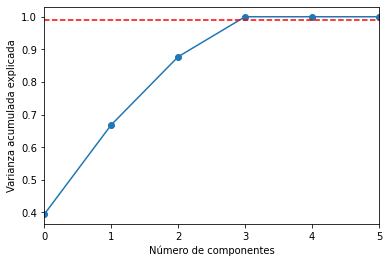

In [16]:
pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.axhline(0.99, color = "r", linestyle = "--")
plt.xlim([0, 5])
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada explicada")
plt.show()

El resultado obtenido es que se puede reducir a 3 variables mediante el PCA perdiendo el mínimo posible de información mientras se reduce la colinearidad también. Se aplicará el PCA a los datos escalados, pero también se entrenarán los modelos sin PCA para ver cómo es su desempeño.Para ello se creará una pipeline de cada una de las opciones. 

In [5]:
models = [
    ("LR", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("SVM", SVC(random_state = 8, probability = True)),
    ("RF", RandomForestClassifier(max_depth=3, random_state=8))
    ]
scalers = [
    ("RobustScaler", RobustScaler()),
    ("QuantileTransformer-Normal", QuantileTransformer(output_distribution = "normal", n_quantiles = 10)),
    ("QuantileTransformer-Uniform", QuantileTransformer(output_distribution = "uniform", n_quantiles = 10)),
    ("PowerTransformer-Yeo-Johnson", PowerTransformer(method = "yeo-johnson"))
          ]
pca = [("PCA", PCA(n_components = 3))
      ]

In [6]:
#create pipelines
pipelines = []
#loop for model scaled
for model in models:
    for scalar in scalers:
        model_name = scalar[0] + "_" + model[0]
        pipelines.append((model_name, Pipeline([scalar, model])))

#loop for model scaled and PCA
for model in models:
    for scalar in scalers:
        for p in pca:
            model_name = scalar[0] + "_" + model[0] + "_" + (p[0])
            pipelines.append((model_name, Pipeline([scalar, p, model])))

A continuación, se hará un gridsearch para ajustar los hiperparámetros de cada algoritmo de manera que estos den un F1 macro lo más alto posible. También se hará una validación cruzada (cross validation) para asegurar esos datos. Se entrenará cada modelo con el subgrupo train, se probará en el test y se calculará el F1 macro. Despues de calcular todos estos datos, se añadirán a un diccionario con el que luego se creará un DataFrame que permitirá encontrar el F1 macro de mayor valor obtenido. Ese será, pues, el modelo que se utilizará para entrenar todo el conjunto de datos y se utilizará para predecir el target. 

In [7]:
#logistic regression hyperparameters
C = [x for x in np.arange(0.1, 3, 0.2)]
penalty = ["l2"]
fit_intercept = [True, False]
lr_params = {"LR__C": C,
             "LR__penalty": penalty,
             "LR__fit_intercept": fit_intercept
            }

#kneighbors hyperparameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = [int(x) for x in np.linspace(start = 5, stop = 50, num = 2)]
p = [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]
knn_params = {"KNN__n_neighbors": n_neighbors,
              "KNN__weights": weights,
              "KNN__algorithm": algorithm,
              "KNN__leaf_size": leaf_size,
              "KNN__p": p
             }

#SVM hyperparameters
C = [x for x in np.arange(0.1, 2, 0.2)]
kernel = ["linear", "poly", "rbf", "sigmoid"]
svm_params = {"SVM__C": C,
              "SVM__kernel": kernel
             }

#random forest hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 20, num = 3)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
rf_params = {"RF__n_estimators": n_estimators,
             "RF__max_features": max_features,
             "RF__max_depth": max_depth,
             "RF__min_samples_split": min_samples_split,
             "RF__min_samples_leaf": min_samples_leaf
            }

In [8]:
#dictionary with all the hyperparameters
hypertuned_params = {"LR": lr_params,
                     "KNN": knn_params,
                     "SVM": svm_params,
                     "RF": rf_params
                    }

In [9]:
# list that contains the rows for the dataframe
rows_list = []

#lists for the pipeline results
results = []
names = []
test_scores = []

#for gridsearch and cross validation score 
cv = KFold(n_splits = 5)

for name, model in pipelines:

    #get model names
    model_name = name.split("_")[1]
    if "-" in model_name:
        model_name = model_name.split("-")[0]
    #get hyper parameters
    if model_name in hypertuned_params.keys():
        random_grid = hypertuned_params[model_name]
    else:
        continue

    #train nested cross validation and gridsearch
    clf = GridSearchCV(estimator = model, param_grid = random_grid, cv = cv, scoring = "f1_macro",
                       error_score = "raise")
    cv_results = cross_val_score(clf, X_train, y_train, cv = cv, scoring = "f1_macro")
    results.append(cv_results)
    names.append(name)

    #print cross validation results of the best classifier
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    #fit on train and predict on test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    curr_test_score = f1_score(y_test, y_pred, average = "macro")
    test_scores.append(curr_test_score)

    #add to dictionary for final dataframe
    results_dict = {"Classifier_Name": name,
                    "CV_mean": cv_results.mean(),
                    "CV_std": cv_results.std(),
                    "F1_score": curr_test_score
                   }
    rows_list.append(results_dict)

First name is :  LR
RobustScaler_LR: 0.519419 (0.041381)
QuantileTransformer-Normal_LR: 0.529825 (0.032646)


C:\Users\Nuria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nuria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

QuantileTransformer-Uniform_LR: 0.516211 (0.023780)
PowerTransformer-Yeo-Johnson_LR: 0.534341 (0.023168)
RobustScaler_KNN: 0.728767 (0.025205)
QuantileTransformer-Normal_KNN: 0.730557 (0.016890)
QuantileTransformer-Uniform_KNN: 0.739862 (0.020169)
PowerTransformer-Yeo-Johnson_KNN: 0.732662 (0.024741)
RobustScaler_SVM: 0.744900 (0.022407)
QuantileTransformer-Normal_SVM: 0.746098 (0.025835)
QuantileTransformer-Uniform_SVM: 0.744373 (0.029688)
PowerTransformer-Yeo-Johnson_SVM: 0.740669 (0.019685)
RobustScaler_RF: 0.745132 (0.026662)
QuantileTransformer-Normal_RF: 0.744419 (0.028708)
QuantileTransformer-Uniform_RF: 0.739454 (0.029239)
PowerTransformer-Yeo-Johnson_RF: 0.745809 (0.027379)
RobustScaler_LR_PCA: 0.403874 (0.017696)
QuantileTransformer-Normal_LR_PCA: 0.398349 (0.019005)
QuantileTransformer-Uniform_LR_PCA: 0.398229 (0.015723)
PowerTransformer-Yeo-Johnson_LR_PCA: 0.395702 (0.016578)
RobustScaler_KNN_PCA: 0.619600 (0.028235)
QuantileTransformer-Normal_KNN_PCA: 0.612637 (0.023061)
Q

In [10]:
#create dataframe with dictionary content
df_results = pd.DataFrame(rows_list)

In [13]:
#save to csv to access it later
df_results.to_csv("results_f1.csv")

In [16]:
#get row with highest f1 score 
df_results.loc[df_results["F1_score"].idxmax()]

Classifier_Name    RobustScaler_KNN
CV_mean                    0.728767
CV_std                     0.025205
F1_score                   0.761051
Name: 4, dtype: object

El F1 macro más alto obtenido es de aproximadamente 0,76 con un valor medio de validación cruzada de 0,73. Se ha obtenido con un escalado previo con RobustScaler, sin aplicar PCA y con el algoritmo KNeighbors. Estos resultados son bastante correctos, por lo que se procederá a reentrenar el modelo con todos los datos que hay en el archivo **train**, y se usará para predecir el target con los datos del archivo **test**. 

## Modelo final

In [45]:
#gridsearch for the definitive model
clf = GridSearchCV(estimator = pipelines[4][1], param_grid = knn_params, cv = cv, scoring = "f1_macro")

#retrain with all the data
result = clf.fit(features, df.target)

In [50]:
print("F1 macro: ", result.best_score_.round(4))

F1 macro:  0.7515


In [52]:
#read test file
df2 = pd.read_csv("space_X_test.csv", index_col = 0)

#predict target on test data
prediction = clf.predict(df2)

#create dataframe with predictions
pred_df = pd.DataFrame(data = prediction, columns = ["target"])

#save as csv 
pred_df.to_csv("Space_X_prediction.csv")